<a href="https://colab.research.google.com/github/brentianpalmer/FinMarketsFinal/blob/main/FinMktsFinal_Method_2_Sensitivity_Analysis_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pricing Function

In [1]:
#@title
import math
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import pprint
from statsmodels.iolib.table import SimpleTable
import pandas as pd
import collections

inputs = {
          'delta': 0.25, 
          'T': 3, 
          'q': 0, 
          'k_stock_lognormal': 1, 
          'k_libor_lognormal': 1,
          'Nsim': 100000, 
          'L0': 0.0034, 
          'sigma_l': 0.08, 
          'sigma_p': 0.05, 
          'rho_sl': 0.65, 
          'xp': [1.0/12, 2.0/12, 3.0/12, 0.5, 1, 2, 3, 5, 7, 10, 20, 30],
          'yp': [0.02,	0.01,	0.02,	0.04,	0.05,	0.16,
                 0.32,	0.80,	1.27,	1.63,	2.20,	2.32], 
          }

def lognormalPricer(inputs):
    outputs = {}
    T = inputs.get('T')
    delta = inputs.get('delta')
    k_stock_lognormal = inputs.get('k_stock_lognormal')
    S0 = 271.27211906501435
    # Japan 3 year government bond yield (from market data (3yr yield)
    r_f = -0.00138
    # -------- Correlations --------- #
    # Correlation stock and exchange rate #
    # Live data # rho_sx = -0.3049678  # correl (NI225 in USD, USD/JPY (DOM exchange rate))
    rho_sx = -0.3049678  # correl (NI225 in USD, USD/JPY (DOM exchange rate))
    # Correl (NI225 in USD, bond maturing in 3 years) *** THIS IS MADE UP ***
    rho_sl = inputs.get('rho_sl')
    rho_sp = -rho_sl
    # -------- Volatilities --------- #
    sigma_s = 0.199468950979314  # Volatility of NI225 in USD
    sigma_x = 0.0519824811701589  # Volatility of USD/JPY (DOM exchange rate).

    quanto_adj = r_f - inputs.get('q') - rho_sx * sigma_s * sigma_x
    girsanov_chg_measure_QT = sigma_s * inputs.get('sigma_p') * rho_sp

    Nsim = inputs.get('Nsim')
    # Process for Generating Correlated Random Samples from Normal distribution from Hull Chapter 21
    np.random.seed(456)
    # random sample from standard normal dist
    rand1 = np.random.normal(0, 1, Nsim)
    # another random sample from different standard normal dist
    rand2 = np.random.normal(0, 1, Nsim)
    eps = rand1  # eps for stock lognormal simulation
    # eps for libor lognormal simulation
    eps_tilda = (rho_sl*rand1)+rand2*np.sqrt(1-rho_sl**2)
    outputs['eps'] = eps
    outputs['eps_tilda'] = eps_tilda

    # As a result, we now can simulate ST with a one-step monte carlo as follows:
    # The MC scheme with vectorized NumPy code handling all paths at once.
    ST = S0 * np.exp((quanto_adj + girsanov_chg_measure_QT-0.5*sigma_s*sigma_s)*
                     T + sigma_s*np.sqrt(T)*eps) 
    ST_avg = np.average(ST)

    # Equity Ratio at time T:
    ST_over_S0 = ST/S0
    ST_over_S0_avg = np.average(ST_over_S0)

    # Equity Ratio vs. strike price k
    ST_over_S0_k = ST_over_S0-k_stock_lognormal
    ST_over_S0_avg_k = ST_over_S0_avg-k_stock_lognormal

    outputs['ST'] = ST
    outputs['ST_avg'] = ST_avg
    outputs['ST_over_S0'] = ST_over_S0
    outputs['ST_over_S0_avg'] = ST_over_S0_avg
    outputs['ST_over_S0_k'] = ST_over_S0_k
    outputs['ST_over_S0_avg_k'] = ST_over_S0_avg_k

    xp = inputs.get('xp')
    yp = inputs.get('yp')
    L0 = inputs.get('L0')

    x_hat = np.arange(0, 30.25, 0.25)
    y_interp = np.interp(x_hat, xp, yp)
    
    # Y(0,T) is the yield-to-maturity on a zero coupon bond maturing at time T, 
    # which we use to calculate p(0,T).
    y_0T = np.interp(T, xp, yp)

    # Y(0,T-delta) is the yield-to-maturity on a zero coupon bond maturing 
    # at time T-delta. This is used to calculated p(0,T-delta).
    y_0Td = np.interp(T-delta, xp, yp)
    
    # p(0,T) is the value at time 0 of receiving a dollar at time T
    # This is also called the discount factor
    p_0T = np.exp(-y_0T/100*T)

    # p(0,T-delta)is the value at time 0 of receiving a dollar at time T-delta
    p_0Td = np.exp(-y_0Td/100*(T-delta)) 

    # sigma_l is the vol of libor
    sigma_l = inputs.get('sigma_l')

    # We then simulate L(T-delta,T-delta,T) via a Monte Carlo simulation 
    # starting at L0
    L_TdTdT = L0 * np.exp(sigma_l * np.sqrt(T - delta) * eps_tilda 
                          - 0.5*sigma_l*sigma_l*(T-delta))
    
    # Average L(T-delta,T-delta,T) # Numerator of payoff
    L_TdTdT_avg = np.average(L_TdTdT) 


    # We then derive from market data for L(0,T-delta,T) 
    # L(0,T-delta,T) is L_0TdT #Denominator of payoff
    L_0TdT = -(p_0T - p_0Td)/(delta*p_0T)

    # Average of L(0,T-delta,T) is L_0TdT #Denominator of payoff L(0,T-delta,T)
    L_0TdT_avg = np.average(L_0TdT)

    # Libor ratio of payoff L(T-delta,T-delta,T) over L(0,T-delta,T)
    L_TdTdT_over_L_0TdT = L_TdTdT/L_0TdT
    L_TdTdT_over_L_0TdT_avg = np.average(L_TdTdT_over_L_0TdT)

    # Get libor strike K from inputs
    k_libor_lognormal = inputs.get('k_libor_lognormal')

    k_L_TdTdT_over_L_0TdT_avg = k_libor_lognormal-L_TdTdT_over_L_0TdT_avg
    
    # Calculate payoff for equity and libor ratios relative to strikes, k, and multiply
    pi = np.maximum(0, np.multiply(
        (ST_over_S0 - k_stock_lognormal), (k_libor_lognormal-L_TdTdT_over_L_0TdT)))
    pi_avg = np.average(pi)

    # Discount pi back to today using p(0,T)
    price = p_0T * pi_avg

    outputs['rho_sp'] = rho_sp
    outputs['x_hat'] = x_hat
    outputs['y_interp'] = y_interp
    outputs['y_0T'] = y_0T
    outputs['y_0Td'] = y_0Td
    outputs['p_0T'] = p_0T
    outputs['p_0Td'] = p_0Td
    outputs['L_0TdT'] = L_0TdT
    outputs['L_0TdT_avg'] = L_0TdT_avg
    outputs['L_TdTdT'] = L_TdTdT
    outputs['L_TdTdT_avg'] = L_TdTdT_avg
    outputs['L_TdTdT_over_L_0TdT'] = L_TdTdT_over_L_0TdT
    outputs['L_TdTdT_over_L_0TdT_avg'] = L_TdTdT_over_L_0TdT_avg
    outputs['k_L_TdTdT_over_L_0TdT_avg'] = k_L_TdTdT_over_L_0TdT_avg
    outputs['pi'] = pi
    outputs['pi_avg'] = pi_avg
    outputs['price'] = price

    return outputs


# print("Complete")



/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Graph Functions

In [2]:
#@title
def stock_graph():
    S0 = inputs.get('S0')
    ST = outputs.get('ST')
    ST_avg = outputs.get('ST_avg')
    x = []
    y = []
    for i in ST:
        y.append(i)
        y.append(S0)
        x.append(1)
        x.append(0)
    plt.figure(figsize=(10, 6))
    plt.title("One-Step Monte Carlo Simulation for Stock")
    plt.plot(x, y, label='paths')
    plt.axhline(ST_avg, color='r', label='mean value of ST')
    plt.legend(loc='upper left')
    plt.xticks()
    plt.xticks(np.arange(0, 1.1, step=1))
    plt.xticks([0, 1], ['0', 'T'])
    print("ST mean: ", ST.mean())
    plt.show()

def ST_outcomes():
    ST = outputs.get('ST')
    ST_avg = outputs.get('ST_avg')
    plt.figure(figsize=(10, 6))
    plt.hist(ST, bins=35, label='ST')
    plt.axvline(ST_avg, color='r', label='ST_avg')
    plt.title("Stock at Time T Outcomes")
    plt.xlabel('Stock Price') # Add an x-label to the axes.
    plt.ylabel('Frequency') # Add a y-label to the axes.
    plt.legend(loc=0)
    print("ST Average: ", ST_avg)
    plt.legend(loc=0)
    plt.show()

def ST_over_SO_outcomes():
    ST_over_S0_avg = outputs.get('ST_over_S0_avg')
    ST_over_S0 = outputs.get('ST_over_S0')
    plt.figure(figsize=(10, 6))
    plt.hist(ST_over_S0, bins=35, label='(ST/SO)')
    plt.title("Stock Payoff (ST/S0)")
    plt.xlabel('(ST/S0)') # Add an x-label to the axes.
    plt.ylabel('Frequency') # Add a y-label to the axes.
    plt.axvline(ST_over_S0_avg, color='r', label='(ST/SO) Avg')
    plt.legend(loc=0)
    print("(ST/S0) Average: ", ST_over_S0_avg)
    plt.legend(loc=0)
    # print("Stock Portion of Payoff ((ST/S0)- k, where k=1): ", ST_over_S0_avg-1)
    plt.show()

def yield_curve_display():
    xp = inputs.get('xp')
    yp = inputs.get('yp')
    x_hat = outputs.get('x_hat')
    y_interp = outputs.get('y_interp')
    plt.figure(figsize=(10, 6))
    plt.plot(xp, yp, 'o', label='US Treasury Yield Curve Constant Maturity Rates')
    plt.title("Interpolated US Treasury Yield Curve Rates on May 10, 2021")
    plt.plot(x_hat, y_interp, 'o', alpha=0.5, label='Interpolated Treasury Yield Curve')
    plt.legend(loc=0)
    plt.xlabel("Maturity")
    plt.ylabel("Yield")
    plt.show()

def TS_info():
    y_0T = outputs.get('y_0T')
    print ("y_0T:", y_0T)
    y_0Td = outputs.get('y_0Td') 
    print ("y_0Td:", y_0Td)
    p_0T = outputs.get('p_0T') 
    print("p_0T: ",p_0T)    
    L0 = inputs.get('L0')
    print("L0: ",L0)

# (L(T-D,T-D,T) / L(0,T-D,T)

def L_TdTdT_Outcomes():
    L_TdTdT = outputs.get('L_TdTdT')
    L_TdTdT_avg = outputs.get('L_TdTdT_avg')
    plt.figure(figsize=(10, 6))
    plt.hist(L_TdTdT, bins=35, label='(L(T-D,T-D,T)')
    plt.axvline(L_TdTdT_avg, color='r', label='(L(T-D,T-D,T) Average')
    plt.title("(L(T-D,T-D,T) Outcomes")
    plt.xlabel('(L(T-D,T-D,T)') # Add an x-label to the axes.
    plt.ylabel('Frequency') # Add a y-label to the axes.
    print("(L(T-D,T-D,T) Average: ", L_TdTdT_avg)
    plt.legend(loc=0)
    plt.show()

def L_TdTdT_over_L_0TdT_Outcomes():
    L_TdTdT_over_L_0TdT = outputs.get('L_TdTdT_over_L_0TdT')
    L_TdTdT_over_L_0TdT_avg = outputs.get('L_TdTdT_over_L_0TdT_avg')
    print("(L(T-D,T-D,T) / L(0,T-D,T) Average: ", L_TdTdT_over_L_0TdT_avg)
    plt.figure(figsize=(10, 6))
    plt.hist(L_TdTdT_over_L_0TdT, bins=35, label='(L(T-D,T-D,T) / L(0,T-D,T)')
    plt.axvline(L_TdTdT_over_L_0TdT_avg, color='r', label='(L(T-D,T-D,T) / L(0,T-D,T) Avg')
    plt.title("(L(T-D,T-D,T) / L(0,T-D,T) Outcomes")
    plt.xlabel('(L(T-D,T-D,T) / L(0,T-D,T)') # Add an x-label to the axes.
    plt.ylabel('Frequency') # Add a y-label to the axes.
    plt.legend(loc=0)
    plt.show()

def pi_outcomes():
    plt.figure(figsize=(10, 6))
    pi = outputs.get('pi')
    pi_avg = outputs.get('pi_avg')
    plt.xlabel('pi') # Add an x-label to the axes.
    plt.ylabel('Frequency') # Add a y-label to the axes.
    plt.hist(pi, bins=50, label='pi')
    plt.axvline(pi_avg, color='r', label='pi Average')
    plt.title("Method 2: Payoff (pi) at T")
    print("Average payoff is: ", pi_avg)
    plt.show()

def display_price():
    price = outputs.get('price')
    print("Discounted Price: ", price)


# Single Simulation

In [3]:
#@title
print("Inputs:")

for k,v in inputs.items():
  print(k,v)

Inputs:
delta 0.25
T 3
q 0
k_stock_lognormal 1
k_libor_lognormal 1
Nsim 100000
L0 0.0034
sigma_l 0.08
sigma_p 0.05
rho_sl 0.65
xp [0.08333333333333333, 0.16666666666666666, 0.25, 0.5, 1, 2, 3, 5, 7, 10, 20, 30]
yp [0.02, 0.01, 0.02, 0.04, 0.05, 0.16, 0.32, 0.8, 1.27, 1.63, 2.2, 2.32]


In [4]:
outputs = lognormalPricer(inputs)

In [5]:
#@title
display_outputs = {key: outputs[key] for key in outputs.keys()
                               & { 'ST_avg', 
'ST_over_S0_avg', 
'ST_over_S0_avg_k',
'y_0T', 'y_0Td', 'p_0T', 'p_0Td' ,'L_0TdT_avg', 'L_TdTdT_avg', 'L_TdTdT_over_L_0TdT_avg', 'pi_avg', 'price'}}

display_outputs_ordered = collections.OrderedDict()

display_outputs_ordered['ST_over_S0_avg'] = display_outputs['ST_over_S0_avg']
display_outputs_ordered['ST_over_S0_avg_k'] = display_outputs['ST_over_S0_avg_k']
display_outputs_ordered['y_0T'] = display_outputs['y_0Td']
display_outputs_ordered['p_0T'] = display_outputs['p_0T']
display_outputs_ordered['p_0Td'] = display_outputs['p_0Td']
display_outputs_ordered['L_0TdT_avg'] = display_outputs['L_0TdT_avg']
display_outputs_ordered['L_TdTdT_avg'] = display_outputs['L_TdTdT_avg']
display_outputs_ordered['L_TdTdT_over_L_0TdT_avg'] = display_outputs['L_TdTdT_over_L_0TdT_avg']
display_outputs_ordered['pi_avg'] = display_outputs['pi_avg']
display_outputs_ordered['price'] = display_outputs['price']

print("Simulation Results:")
for k, v in display_outputs_ordered.items():
    print (k, v)


Simulation Results:
ST_over_S0_avg 0.98553392905389
ST_over_S0_avg_k -0.014466070946109966
y_0T 0.28
p_0T 0.990445932897216
p_0Td 0.9923295690574124
L_0TdT_avg 0.007607224574839476
L_TdTdT_avg 0.0033990630679548712
L_TdTdT_over_L_0TdT_avg 0.44682039218312375
pi_avg 0.06387512520111031
price 0.06326485796874018


ST Average:  267.34787734491834


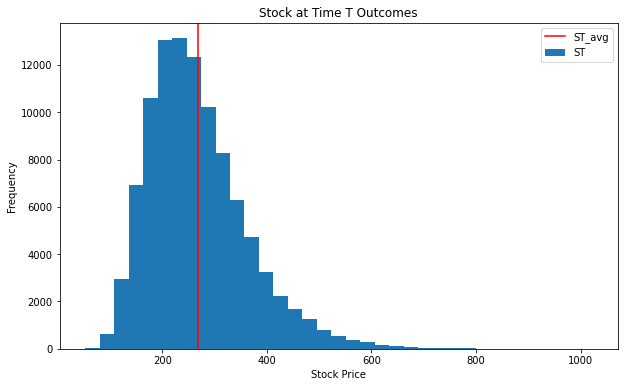

(ST/S0) Average:  0.98553392905389


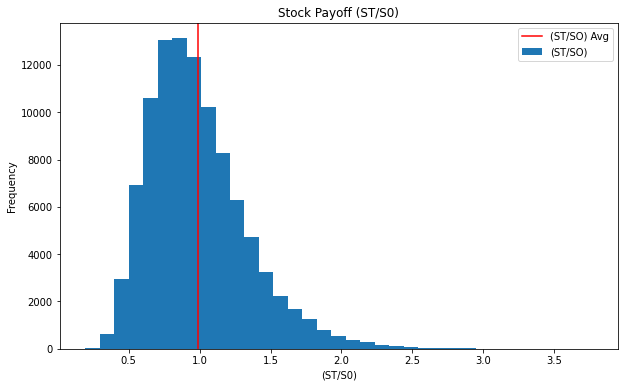

In [6]:
#@title

# stock_graph()

ST_outcomes()
ST_over_SO_outcomes()


In [7]:
#@title
df_results = pd.DataFrame.from_dict([display_outputs_ordered])
df_results
df_results.to_excel("df_results.xlsx", sheet_name='Sheet_name_1')

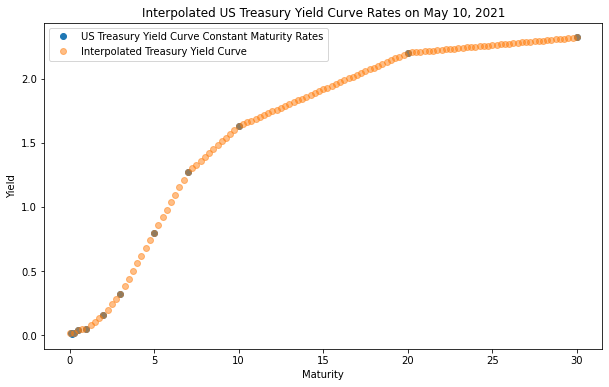

y_0T: 0.32
y_0Td: 0.28
p_0T:  0.990445932897216
L0:  0.0034


In [8]:
yield_curve_display()
TS_info()

(L(T-D,T-D,T) Average:  0.0033990630679548712


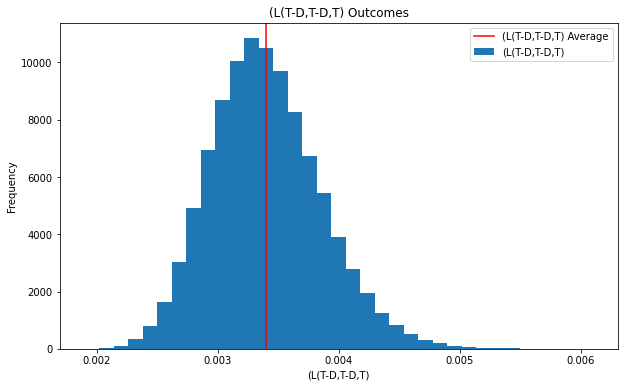

(L(T-D,T-D,T) / L(0,T-D,T) Average:  0.44682039218312375


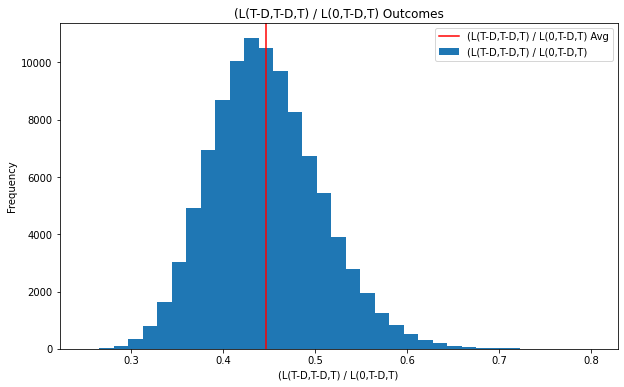

In [9]:
L_TdTdT_Outcomes()
L_TdTdT_over_L_0TdT_Outcomes()


Average payoff is:  0.06387512520111031


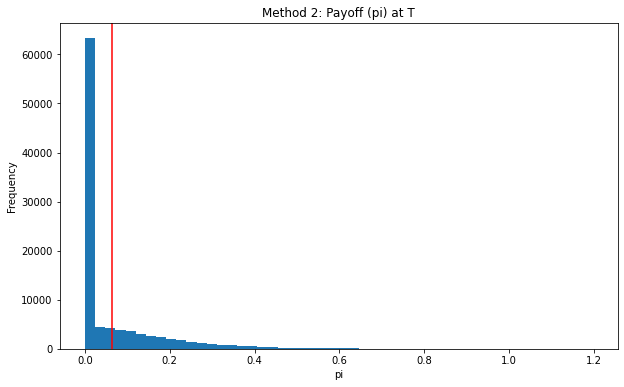

Discounted Price:  0.06326485796874018


In [10]:
pi_outcomes()
display_price()

# Toggle Stock K from 0 to 2

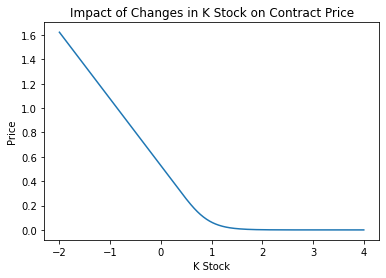

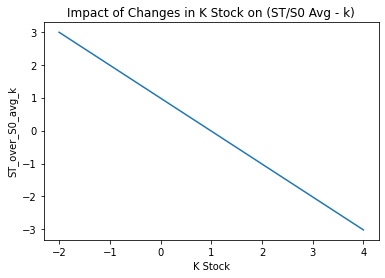

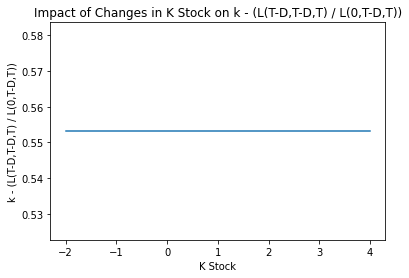

In [11]:
#@title
k_stock_values = np.arange(-2, 4.01, 0.01).tolist()
toggle_k_stock = []

# print(toggle_k_stock)

for k in k_stock_values:
  inputs_k = inputs.copy()
  inputs_k.update({'k_stock_lognormal': k})
  toggle_k_stock.append(inputs_k)

# for d in toggle_k_stock:
#   print(d)

toggle_k_stock_outputs = []

for i in toggle_k_stock:
  outputs = lognormalPricer(i)
  toggle_k_stock_outputs.append(outputs)

# df_toggle_k_stock_outputs

# for d in toggle_k_stock_outputs:
#   print(d['price'])

# df_toggle_k_stock_outputs = pd.DataFrame[x.pop() for x in mwe]

toggle_k_stock_prices = [d['price'] for d in toggle_k_stock_outputs]
# toggle_k_stock_prices


k_stock_values
plt.plot(k_stock_values, toggle_k_stock_prices )
plt.title('Impact of Changes in K Stock on Contract Price') # Add a title to the plot.
plt.xlabel('K Stock') # Add an x-label to the axes.
plt.ylabel('Price') # Add a y-label to the axes.
plt.savefig('k_stock_plots1.png')

toggle_k_stock_outputs_ST_over_S0_avg = [d['ST_over_S0_avg_k'] for d in toggle_k_stock_outputs]
plt.subplots(1)
plt.title('Impact of Changes in K Stock on (ST/S0 Avg - k)')
plt.plot(k_stock_values, toggle_k_stock_outputs_ST_over_S0_avg )
plt.xlabel('K Stock') # Add an x-label to the axes.
plt.ylabel('ST_over_S0_avg_k') # Add a y-label to the axes.
plt.savefig('k_stock_plots2.png')
toggle_k_stock_outputs_L_TdTdT_over_L_0TdT_avg = [d['k_L_TdTdT_over_L_0TdT_avg'] for d in toggle_k_stock_outputs]
plt.subplots(1)
plt.title('Impact of Changes in K Stock on k - (L(T-D,T-D,T) / L(0,T-D,T))')
plt.plot(k_stock_values, toggle_k_stock_outputs_L_TdTdT_over_L_0TdT_avg )
plt.xlabel('K Stock') # Add an x-label to the axes.
plt.ylabel('k - (L(T-D,T-D,T) / L(0,T-D,T))') # Add a y-label to the axes.
plt.savefig('k_stock_plots3.png')

df_toggle_k_stock = pd.DataFrame(list(zip(k_stock_values, toggle_k_stock_prices)),
               columns =['k', 'price'])
df_toggle_k_stock
df_toggle_k_stock.to_excel("df_toggle_k_stock.xlsx", sheet_name='Sheet_name_1')

# Toggle Libor K from 0 to 2

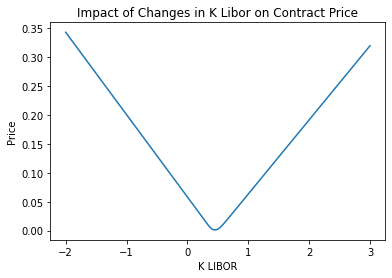

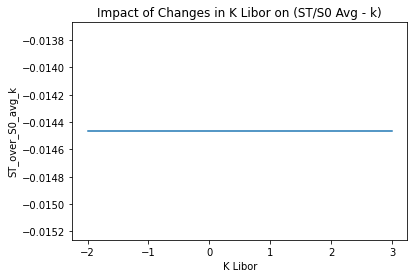

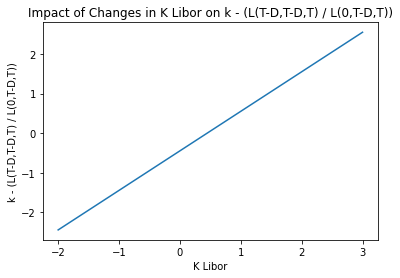

In [12]:
#@title
k_libor_values = np.arange(-2, 3.01, 0.01).tolist()
toggle_k_libor = []

# print(toggle_k_libor)

for k in k_libor_values:
  inputs_k = inputs.copy()
  inputs_k.update({'k_libor_lognormal': k})
  toggle_k_libor.append(inputs_k)

# Uncomment to print all output results
# for d in toggle_k_libor:
#   print(d)

toggle_k_libor_outputs = []

for i in toggle_k_libor:
  outputs = lognormalPricer(i)
  toggle_k_libor_outputs.append(outputs)

# df_toggle_k_libor_outputs

# for d in toggle_k_libor_outputs:
#   print(d['price'])

toggle_k_libor_prices = [d['price'] for d in toggle_k_libor_outputs]
# toggle_k_libor_prices

k_libor_values
plt.plot(k_libor_values, toggle_k_libor_prices )
plt.title('Impact of Changes in K Libor on Contract Price') # Add a title to the plot.
plt.xlabel('K LIBOR') # Add an x-label to the axes.
plt.ylabel('Price') # Add a y-label to the axes.
plt.savefig('k_libor_plots1.png')

toggle_k_libor_outputs_ST_over_S0_avg = [d['ST_over_S0_avg_k'] for d in toggle_k_libor_outputs]
plt.subplots(1)
plt.title('Impact of Changes in K Libor on (ST/S0 Avg - k)')
plt.plot(k_libor_values, toggle_k_libor_outputs_ST_over_S0_avg )
plt.xlabel('K Libor') # Add an x-label to the axes.
plt.ylabel('ST_over_S0_avg_k') # Add a y-label to the axes.
plt.savefig('k_libor_plots2.png')
toggle_k_libor_outputs_L_TdTdT_over_L_0TdT_avg = [d['k_L_TdTdT_over_L_0TdT_avg'] for d in toggle_k_libor_outputs]
plt.subplots(1)
plt.title('Impact of Changes in K Libor on k - (L(T-D,T-D,T) / L(0,T-D,T))')
plt.plot(k_libor_values, toggle_k_libor_outputs_L_TdTdT_over_L_0TdT_avg )
plt.xlabel('K Libor') # Add an x-label to the axes.
plt.ylabel('k - (L(T-D,T-D,T) / L(0,T-D,T))') # Add a y-label to the axes.
plt.savefig('k_libor_plots3.png')

df_toggle_k_libor = pd.DataFrame(list(zip(k_libor_values, toggle_k_libor_prices)),
               columns =['k', 'price'])
df_toggle_k_libor
df_toggle_k_libor.to_excel("df_toggle_k_libor.xlsx", sheet_name='Sheet_name_1')

# Toggle L0 from 0.0001 to 0.0040

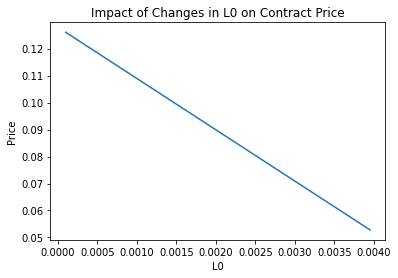

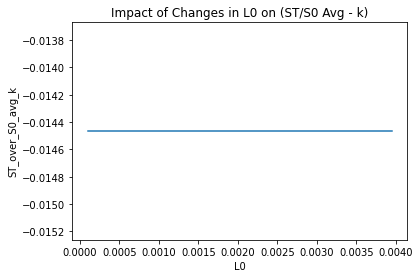

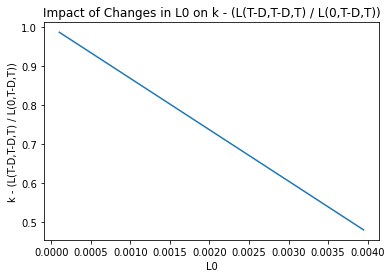

In [13]:
#@title
L0_values = np.arange(0.0001, 0.004, 0.00005).tolist()
toggle_L0 = []

# print(toggle_L0)

for k in L0_values:
  inputs_k = inputs.copy()
  inputs_k.update({'L0': k})
  toggle_L0.append(inputs_k)

# Uncomment to print all output results
# for d in toggle_L0:
#   print(d)

toggle_L0_outputs = []

for i in toggle_L0:
  outputs = lognormalPricer(i)
  toggle_L0_outputs.append(outputs)

# df_toggle_L0_outputs

# for d in toggle_L0_outputs:
#   print(d['price'])

toggle_L0_prices = [d['price'] for d in toggle_L0_outputs]
# toggle_L0_prices

L0_values
plt.plot(L0_values, toggle_L0_prices)
plt.title('Impact of Changes in L0 on Contract Price') # Add a title to the plot.
plt.xlabel('L0') # Add an x-label to the axes.
plt.ylabel('Price') # Add a y-label to the axes.
plt.savefig('L0_plots1.png')
toggle_L0_outputs_ST_over_S0_avg = [d['ST_over_S0_avg_k'] for d in toggle_L0_outputs]
plt.subplots(1)
plt.title('Impact of Changes in L0 on (ST/S0 Avg - k)')
plt.plot(L0_values, toggle_L0_outputs_ST_over_S0_avg )
plt.xlabel('L0') # Add an x-label to the axes.
plt.ylabel('ST_over_S0_avg_k') # Add a y-label to the axes.
plt.savefig('L0_plots2.png')

toggle_L0_outputs_L_TdTdT_over_L_0TdT_avg = [d['k_L_TdTdT_over_L_0TdT_avg'] for d in toggle_L0_outputs]
plt.subplots(1)
plt.title('Impact of Changes in L0 on k - (L(T-D,T-D,T) / L(0,T-D,T))')
plt.plot(L0_values, toggle_L0_outputs_L_TdTdT_over_L_0TdT_avg )
plt.xlabel('L0') # Add an x-label to the axes.
plt.ylabel('k - (L(T-D,T-D,T) / L(0,T-D,T))') # Add a y-label to the axes.
plt.savefig('L0_plots3.png')

df_toggle_L0 = pd.DataFrame(list(zip(L0_values, toggle_L0_prices)),
               columns =['L0', 'price'])
df_toggle_L0
df_toggle_L0.to_excel("df_toggle_L0.xlsx", sheet_name='Sheet_name_1')


# Toggle rho_SL from -1 to 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in sqrt


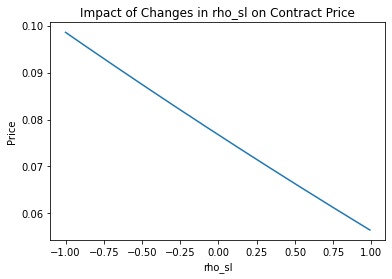

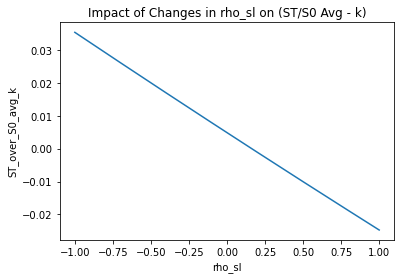

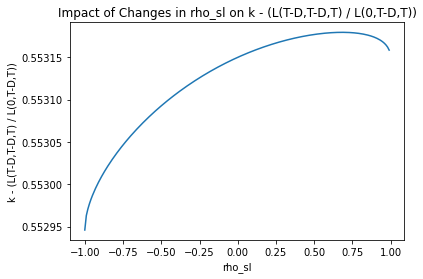

In [14]:
#@title
rho_sl_values = np.arange(-1.0, 1.01, 0.01).tolist()
toggle_rho_sl = []

# print(toggle_rho_sl)

for k in rho_sl_values:
  inputs_k = inputs.copy()
  inputs_k.update({'rho_sl': k})
  toggle_rho_sl.append(inputs_k)

# Uncomment to print all output results
# for d in toggle_rho_sl:
#   print(d)

toggle_rho_sl_outputs = []

for i in toggle_rho_sl:
  outputs = lognormalPricer(i)
  toggle_rho_sl_outputs.append(outputs)

# df_toggle_rho_sl_outputs

# for d in toggle_rho_sl_outputs:
#   print(d['price'])

toggle_rho_sl_prices = [d['price'] for d in toggle_rho_sl_outputs]
# toggle_rho_sl_prices

rho_sl_values
plt.plot(rho_sl_values, toggle_rho_sl_prices)
plt.title('Impact of Changes in rho_sl on Contract Price') # Add a title to the plot.
plt.xlabel('rho_sl') # Add an x-label to the axes.
plt.ylabel('Price') # Add a y-label to the axes.
plt.savefig('rho_SL_plots1.png')

toggle_rho_sl_outputs_ST_over_S0_avg = [d['ST_over_S0_avg_k'] for d in toggle_rho_sl_outputs]
plt.subplots(1)
plt.title('Impact of Changes in rho_sl on (ST/S0 Avg - k)')
plt.plot(rho_sl_values, toggle_rho_sl_outputs_ST_over_S0_avg )
plt.xlabel('rho_sl') # Add an x-label to the axes.
plt.ylabel('ST_over_S0_avg_k') # Add a y-label to the axes.
plt.savefig('rho_SL_plots2.png')
toggle_rho_sl_outputs_L_TdTdT_over_L_0TdT_avg = [d['k_L_TdTdT_over_L_0TdT_avg'] for d in toggle_rho_sl_outputs]
plt.subplots(1)
plt.title('Impact of Changes in rho_sl on k - (L(T-D,T-D,T) / L(0,T-D,T))')
plt.plot(rho_sl_values, toggle_rho_sl_outputs_L_TdTdT_over_L_0TdT_avg )
plt.xlabel('rho_sl') # Add an x-label to the axes.
plt.ylabel('k - (L(T-D,T-D,T) / L(0,T-D,T))') # Add a y-label to the axes.
plt.savefig('rho_SL_plots3.png')
df_toggle_rho_sl = pd.DataFrame(list(zip(rho_sl_values, toggle_rho_sl_prices)),
               columns =['rho_sl', 'price'])
df_toggle_rho_sl
df_toggle_rho_sl.to_excel("df_toggle_rho_sl.xlsx", sheet_name='Sheet_name_1')



# Toggle sigma_l from 0 to 100

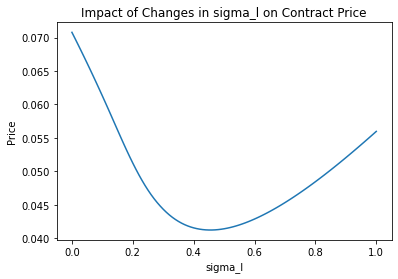

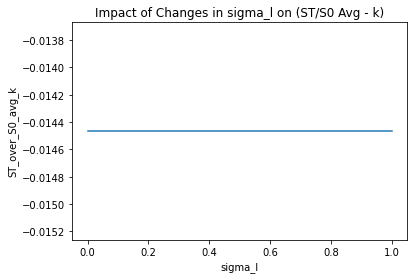

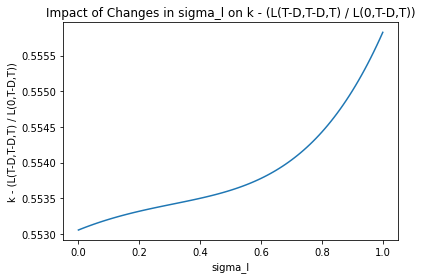

In [15]:
#@title
sigma_l_values = np.arange(0, 1.01, 0.01).tolist()
toggle_sigma_l = []

# print(toggle_sigma_l)

for k in sigma_l_values:
  inputs_k = inputs.copy()
  inputs_k.update({'sigma_l': k})
  toggle_sigma_l.append(inputs_k)

# Uncomment to print all output results
# for d in toggle_sigma_l:
#   print(d)

toggle_sigma_l_outputs = []

for i in toggle_sigma_l:
  outputs = lognormalPricer(i)
  toggle_sigma_l_outputs.append(outputs)

# df_toggle_sigma_l_outputs

# for d in toggle_sigma_l_outputs:
#   print(d['price'])

toggle_sigma_l_prices = [d['price'] for d in toggle_sigma_l_outputs]
# toggle_sigma_l_prices

sigma_l_values
plt.plot(sigma_l_values, toggle_sigma_l_prices)
plt.title('Impact of Changes in sigma_l on Contract Price') # Add a title to the plot.
plt.xlabel('sigma_l') # Add an x-label to the axes.
plt.ylabel('Price') # Add a y-label to the axes.
plt.savefig('sigma_l_plots1.png')
toggle_sigma_l_outputs_ST_over_S0_avg = [d['ST_over_S0_avg_k'] for d in toggle_sigma_l_outputs]
plt.subplots(1)
plt.title('Impact of Changes in sigma_l on (ST/S0 Avg - k)')
plt.plot(sigma_l_values, toggle_sigma_l_outputs_ST_over_S0_avg )
plt.xlabel('sigma_l') # Add an x-label to the axes.
plt.ylabel('ST_over_S0_avg_k') # Add a y-label to the axes.
plt.savefig('sigma_l_plots2.png')
toggle_sigma_l_outputs_L_TdTdT_over_L_0TdT_avg = [d['k_L_TdTdT_over_L_0TdT_avg'] for d in toggle_sigma_l_outputs]
plt.subplots(1)
plt.title('Impact of Changes in sigma_l on k - (L(T-D,T-D,T) / L(0,T-D,T))')
plt.plot(sigma_l_values, toggle_sigma_l_outputs_L_TdTdT_over_L_0TdT_avg )
plt.xlabel('sigma_l') # Add an x-label to the axes.
plt.ylabel('k - (L(T-D,T-D,T) / L(0,T-D,T))') # Add a y-label to the axes.
plt.savefig('sigma_l_plots3.png')
df_toggle_sigma_l = pd.DataFrame(list(zip(sigma_l_values, toggle_sigma_l_prices)),
               columns =['sigma_l', 'price'])
df_toggle_sigma_l
df_toggle_sigma_l.to_excel("df_toggle_sigma_l.xlsx", sheet_name='Sheet_name_1')
# print(toggle_sigma_l_outputs_L_TdTdT_over_L_0TdT_avg)

# Toggle sigma_p from 0 to 200

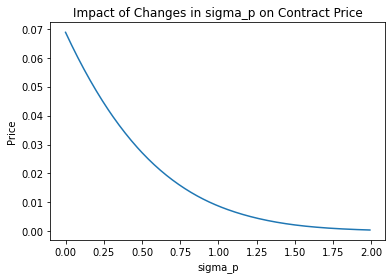

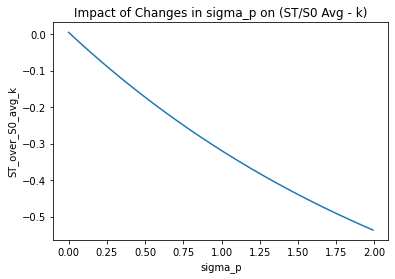

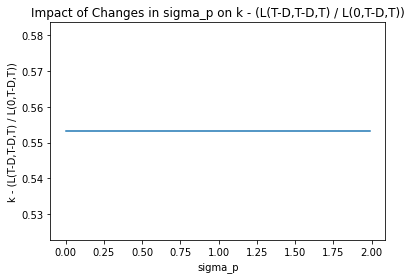

In [16]:
#@title
sigma_p_values = np.arange(0, 2, 0.01).tolist()
toggle_sigma_p = []

# print(toggle_sigma_p)

for k in sigma_p_values:
  inputs_k = inputs.copy()
  inputs_k.update({'sigma_p': k})
  toggle_sigma_p.append(inputs_k)

# Uncomment to print all output results
# for d in toggle_sigma_p:
#   print(d)

toggle_sigma_p_outputs = []

for i in toggle_sigma_p:
  outputs = lognormalPricer(i)
  toggle_sigma_p_outputs.append(outputs)

# df_toggle_sigma_p_outputs

# for d in toggle_sigma_p_outputs:
#   print(d['price'])

toggle_sigma_p_prices = [d['price'] for d in toggle_sigma_p_outputs]
# toggle_sigma_p_prices

sigma_p_values
plt.plot(sigma_p_values, toggle_sigma_p_prices)
plt.title('Impact of Changes in sigma_p on Contract Price') # Add a title to the plot.
plt.xlabel('sigma_p') # Add an x-label to the axes.
plt.ylabel('Price') # Add a y-label to the axes.
plt.savefig('sigma_p_plots1.png')
toggle_sigma_p_outputs_ST_over_S0_avg = [d['ST_over_S0_avg_k'] for d in toggle_sigma_p_outputs]
plt.subplots(1)
plt.title('Impact of Changes in sigma_p on (ST/S0 Avg - k)')
plt.plot(sigma_p_values, toggle_sigma_p_outputs_ST_over_S0_avg )
plt.xlabel('sigma_p') # Add an x-label to the axes.
plt.ylabel('ST_over_S0_avg_k') # Add a y-label to the axes.
plt.savefig('sigma_p_plots2.png')
toggle_sigma_p_outputs_L_TdTdT_over_L_0TdT_avg = [d['k_L_TdTdT_over_L_0TdT_avg'] for d in toggle_sigma_p_outputs]
plt.subplots(1)
plt.title('Impact of Changes in sigma_p on k - (L(T-D,T-D,T) / L(0,T-D,T))')
plt.plot(sigma_p_values, toggle_sigma_p_outputs_L_TdTdT_over_L_0TdT_avg )
plt.xlabel('sigma_p') # Add an x-label to the axes.
plt.ylabel('k - (L(T-D,T-D,T) / L(0,T-D,T))') # Add a y-label to the axes.
plt.savefig('sigma_p_plots3.png')
df_toggle_sigma_p = pd.DataFrame(list(zip(sigma_p_values, toggle_sigma_p_prices)),
               columns =['sigma_p', 'price'])
df_toggle_sigma_p
df_toggle_sigma_p.to_excel("df_toggle_sigma_p.xlsx", sheet_name='Sheet_name_1')

# Toggle T from 0 to 3.5

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:110: RuntimeWarning: invalid value encountered in sqrt


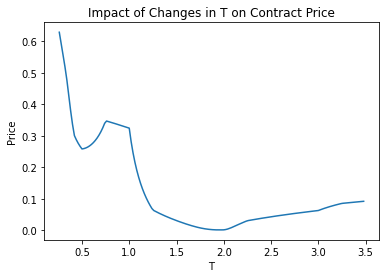

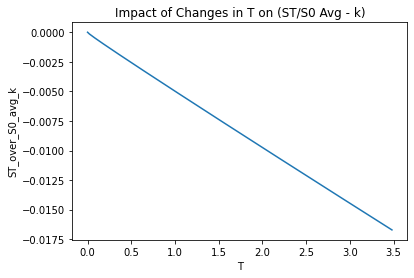

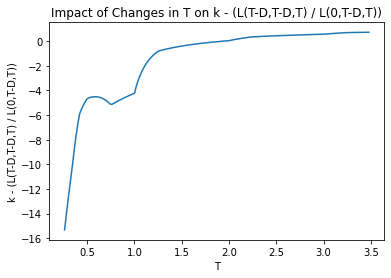

In [17]:
#@title
T_values = np.arange(0, 3.5, 0.02).tolist()
toggle_T = []

# print(toggle_T)

for k in T_values:
  inputs_k = inputs.copy()
  inputs_k.update({'T': k})
  toggle_T.append(inputs_k)

# Uncomment to print all output results
# for d in toggle_T:
#   print(d)

toggle_T_outputs = []

for i in toggle_T:
  outputs = lognormalPricer(i)
  toggle_T_outputs.append(outputs)

# df_toggle_T_outputs

# for d in toggle_T_outputs:
#   print(d['price'])

toggle_T_prices = [d['price'] for d in toggle_T_outputs]
# toggle_T_prices

T_values
plt.plot(T_values, toggle_T_prices)
plt.title('Impact of Changes in T on Contract Price') # Add a title to the plot.
plt.xlabel('T') # Add an x-label to the axes.
plt.ylabel('Price') # Add a y-label to the axes.
plt.savefig('T_plots1.png')
toggle_T_outputs_ST_over_S0_avg = [d['ST_over_S0_avg_k'] for d in toggle_T_outputs]
plt.subplots(1)
plt.title('Impact of Changes in T on (ST/S0 Avg - k)')
plt.plot(T_values, toggle_T_outputs_ST_over_S0_avg )
plt.xlabel('T') # Add an x-label to the axes.
plt.ylabel('ST_over_S0_avg_k') # Add a y-label to the axes.
plt.savefig('T_plots2.png')
toggle_T_outputs_L_TdTdT_over_L_0TdT_avg = [d['k_L_TdTdT_over_L_0TdT_avg'] for d in toggle_T_outputs]
plt.subplots(1)
plt.title('Impact of Changes in T on k - (L(T-D,T-D,T) / L(0,T-D,T))')
plt.plot(T_values, toggle_T_outputs_L_TdTdT_over_L_0TdT_avg )
plt.xlabel('T') # Add an x-label to the axes.
plt.ylabel('k - (L(T-D,T-D,T) / L(0,T-D,T))') # Add a y-label to the axes.
plt.savefig('T_plots3.png')
df_toggle_T = pd.DataFrame(list(zip(T_values, toggle_T_prices)),
               columns =['T', 'price'])
df_toggle_T
df_toggle_T.to_excel("df_toggle_T.xlsx", sheet_name='Sheet_name_1')

# Toggle Q from 0% to 50%

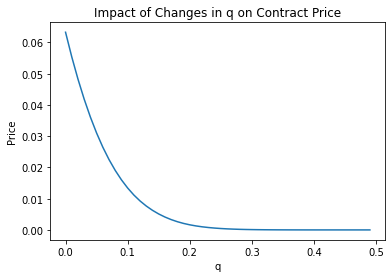

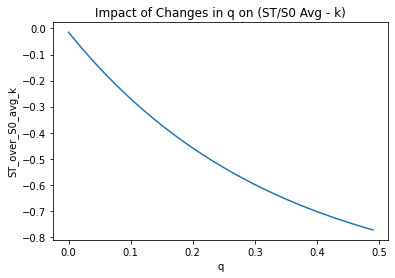

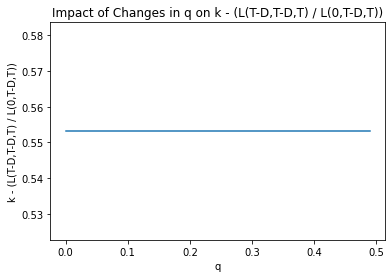

In [18]:
#@title
q_values = np.arange(0, 0.5, 0.01).tolist()
toggle_q = []

# print(toggle_q)

for k in q_values:
  inputs_k = inputs.copy()
  inputs_k.update({'q': k})
  toggle_q.append(inputs_k)

# Uncomment to print all output results
# for d in toggle_q:
#   print(d)

toggle_q_outputs = []

for i in toggle_q:
  outputs = lognormalPricer(i)
  toggle_q_outputs.append(outputs)

# df_toggle_q_outputs

# for d in toggle_q_outputs:
#   print(d)

toggle_q_prices = [d['price'] for d in toggle_q_outputs]
# toggle_q_prices

q_values
plt.subplots(1)
plt.plot(q_values, toggle_q_prices)
plt.title('Impact of Changes in q on Contract Price') # Add a title to the plot.
plt.xlabel('q') # Add an x-label to the axes.
plt.ylabel('Price') # Add a y-label to the axes.
plt.savefig('q_plots1.png')
toggle_q_outputs_ST_over_S0_avg = [d['ST_over_S0_avg_k'] for d in toggle_q_outputs]
plt.subplots(1)
plt.title('Impact of Changes in q on (ST/S0 Avg - k)')
plt.plot(q_values, toggle_q_outputs_ST_over_S0_avg )
plt.xlabel('q') # Add an x-label to the axes.
plt.ylabel('ST_over_S0_avg_k') # Add a y-label to the axes.
plt.savefig('q_plots2.png')
toggle_q_outputs_L_TdTdT_over_L_0TdT_avg = [d['k_L_TdTdT_over_L_0TdT_avg'] for d in toggle_q_outputs]
plt.subplots(1)
plt.title('Impact of Changes in q on k - (L(T-D,T-D,T) / L(0,T-D,T))')
plt.plot(q_values, toggle_q_outputs_L_TdTdT_over_L_0TdT_avg )
plt.xlabel('q') # Add an x-label to the axes.
plt.ylabel('k - (L(T-D,T-D,T) / L(0,T-D,T))') # Add a y-label to the axes.
plt.savefig('q_plots3.png')
df_toggle_q = pd.DataFrame(list(zip(q_values, toggle_q_prices)),
               columns =['q', 'price'])
df_toggle_q
df_toggle_q.to_excel("df_toggle_q.xlsx", sheet_name='Sheet_name_1')